In [3]:
import os

import numpy as np

In [5]:
os.chdir("..")
os.getcwd()

'/Users/mariusmahiout/Documents/repos/ising_core/python/src'

In [26]:
data_folder = "../../data/"

mouse_name = "Angie"
num_units = 50
params = np.load(data_folder + "params/" + f'params_{mouse_name}_{num_units}.npy', allow_pickle=True).item()

In [27]:
eq_couplings = params["eq_couplings"]
eq_fields = params["neq_fields"]

neq_couplings = params["eq_couplings"]
neq_fields = params["neq_fields"]

In [28]:
import matplotlib.pyplot as plt

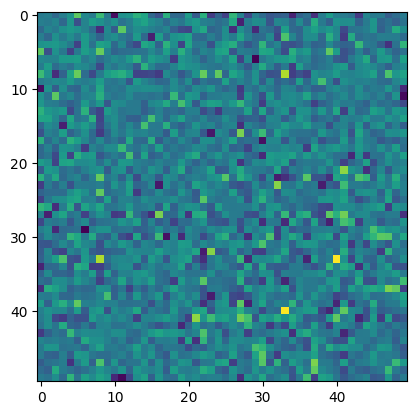

In [29]:
plt.imshow(eq_couplings)

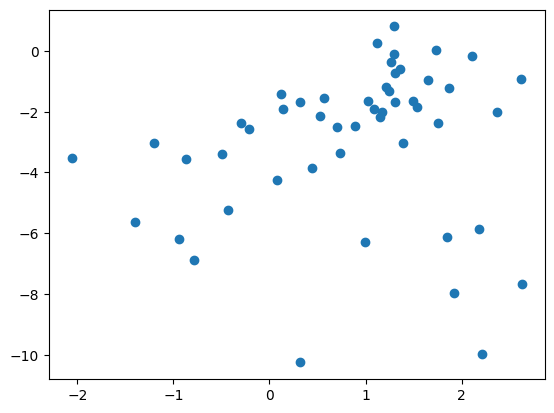

In [55]:
def get_coupling_sums(J):    
    num_units = len(J)
    coupling_sums = [0 for _ in range(num_units)]
    for i in range(num_units):
        for j in [k for k in range(num_units) if k != i]:
            coupling_sums[i] += J[i, j]
    return coupling_sums

J_sums = get_coupling_sums(neq_couplings)

plt.scatter(J_sums, neq_fields)



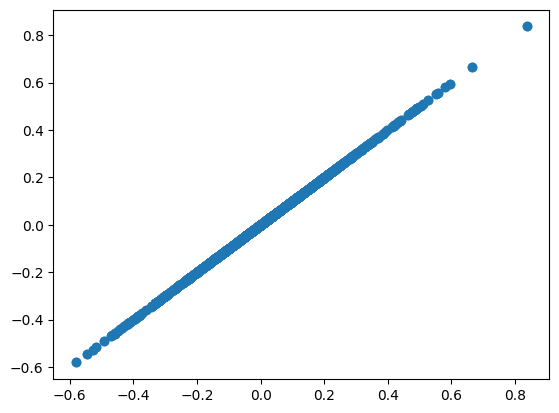

In [56]:
plt.scatter(eq_couplings, neq_couplings)

In [20]:
eq_couplings[1,1]

0.0

# Parameter analysis

Here we're going to do a bit of parameter analysis -- this is the place to build plots such as network graphs, coupling distribution plots etc.

Some ideas:
- Can we say anything about the distribution of couplings? Such as
    - Probability distribution
    - Network structure (e.g., small-world) Note: maybe check what we might expect in M2 and PPC -- would be great to see some characteristic signs of connectivity!

- Are the fields log-normally distributed? I heard somewhere that the mean firing rate should have this distribution, and I guess the fields contribute to this


- I think the Hamiltonian can be computed on the basis of fields, couplings, and a state, so we can track the energy of states during simulation with this!
The energy will basically be a 1-D time series
- In this way, can we obtain a distribution over energies by sampling?